# Report 03
### Yuzhong Huang

In [1]:
# imports tools for solving bayes problems

from __future__ import print_function, division

import numpy as np
import math

import thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite, Joint
import thinkplot

% matplotlib inline

## The cat problem from ThinkBayes chap05

Suppose you are having a dinner party with 10 guests and 4 of them are allergic to cats. Because you have cats, you expect 50% of the allergic guests to sneeze during dinner. At the same time, you expect 10% of the non-allergic guests to sneeze. What is the distribution of the total number of guests who sneeze?

#### My solution follows

The distribution of the total number of guests who sneeze is composed by the distribution of the allergic guests and the non-allegric guests. Therefore, we will first need to compute the distribution of them separately, and then mix the two distributions

In [17]:
# compute distribution of allergic guests

allergic_g = 4
p_allergic = 0.5

pmf_allergic = thinkbayes2.MakeBinomialPmf(allergic_g, p_allergic)

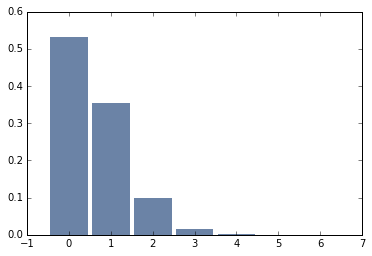

In [18]:
# compute distribution of non-allergic guests

non_g = 6
p_non = 0.1

pmf_non = thinkbayes2.MakeBinomialPmf(non_g, p_non)
thinkplot.Hist(pmf_non)

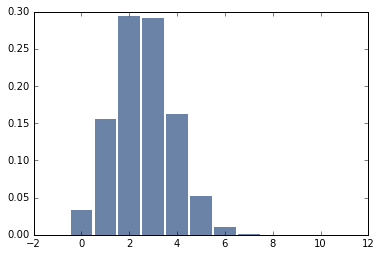

In [19]:
# Total distribution

pmf_total = pmf_allergic + pmf_non
thinkplot.Hist(pmf_total)

That is a strightforward problem solving. Now let's consider the reverse of that problem. What if the number of people allergic to cat is unknown. And there are 4 persons sneezing during the dinner. What's the distribution of number of allergic people among those guests?

To solve that problem, we need to computes the likelihood of having 4 persons sneezed during the dinner under every possible distribution

In [20]:
# create a list of all the possible pmfs of guest with variable numbers of allegric guests from 0 to 10

pmfs = []
p_non = 0.1
p_allergic = 0.5

for allergic_g in range(11):
    pmfs.append(thinkbayes2.MakeBinomialPmf(10-allergic_g, p_non) + thinkbayes2.MakeBinomialPmf(allergic_g, p_allergic))

In [21]:
# then use bayesian inference to generates a list of likelihood

likelihoods = [pmf[4] for pmf in pmfs]

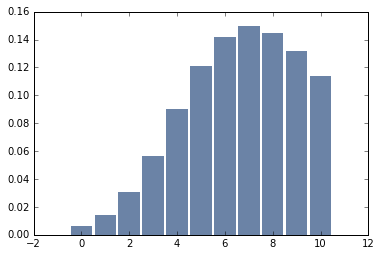

In [22]:
# create a pmf to represents the distribution of likelihoods
guest_pmf = Pmf()
for i in range(11):
    guest_pmf[i] = likelihoods[i]
    
guest_pmf.Normalize()
thinkplot.Hist(guest_pmf)

As we can see, the most likely number of allergic people during the dinner is 7.

## Lincoln index problem from ThinkBayes chap09

Note that the question is originally from http://www.johndcook.com/blog/2010/07/13/lincoln-index/

"Suppose you have a tester who finds 20 bugs in your program. You want to estimate how many bugs are really in the program. You know there are at least 20 bugs, and if you have supreme confidence in your tester, you may suppose there are around 20 bugs. But maybe your tester isn't very good. Maybe there are hundreds of bugs. How can you have any idea how many bugs there are? There’s no way to know with one tester. But if you have two testers, you can get a good idea, even if you don’t know how skilled the testers are.
Suppose two testers independently search for bugs. Let k1 be the number of errors the first tester finds and k2 the number of errors the second tester finds. Let c be the number of errors both testers find. The Lincoln Index estimates the total number of errors as k1 k2 / c [I changed his notation to be consistent with mine]."
So if the first tester finds 20 bugs, the second finds 15, and they find 3 in common, we estimate that there are about 100 bugs. What is the Bayesian estimate of the number of errors based on this data?

#### My solution follows

Since it is a bayesian inference problem, I will construct a class for Lincoln index problem to represent the hypothesis on how many errors are actually there in the program. Then, we need to consider what is the likelihood of the data given certain hypothesis.

Since the data tells us that there are 20 errors found by debuger 1 and 15 found by debuger 2 and there are 3 common errors. The likelihood of that data under hypothesis that there are n errors in total and the chance of debuger are p1 and p2 respectively. The likelihood therefore is the multiplication of chance that debuger 1 found 20 bugs from n errors in total, and the chance that debuger 2 found 15 errors out of n total errors with 3 errors in common with debuger 1.

In [37]:
def binomial(k, n, p):
    return p**k * (1-p)**(n-k)

def C(n, k):
    return math.factorial(n) / (math.factorial(k) * math.factorial(n-k))

class Lincoln(Suite, Joint):
    """Represents hypotheses about the number of errors."""

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: n, p1, p2
        data: k1, k2, c
        """
        n, p1, p2 = hypo
        k1, k2, c = data

        debuger1 = binomial(k1, n, p1) * C(n, k1)
        debuger2 = C(k1, c) * C(n-k1, k2-c) * binomial(k2, n, p2)
        return debuger1 * debuger2

Now we will use the class we constructed to solve the lincoln index problem. First, our data is 20 errors, 15 erros and 3 common errors. And the possible value of n should be larger than 15 + 20 - 3 = 32. Also the probablity of debuger 1 should be no larger than 20/32 = 0.625; the probablity of debuger 2 should be at most 15/32. Since p1 = 20/n and p2 = 15/n

Let's suppose the max value of n here is 700 bugs

In [41]:
data = 20, 15, 3
hypos = []
for n in range(32, 700):
    p1 = data[0] / n
    p2 = data[1] / n
    hypos.append((n, p1, p2))

suite = Lincoln(hypos)
suite.Update(data)

0.0007411746273158978

Now let's plot the pmf to visualize the chance of numbers of bugs given the data

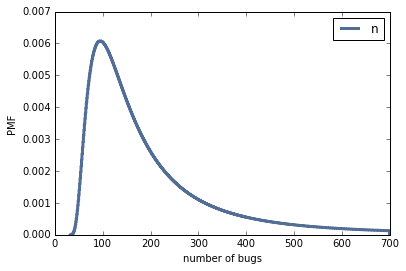

In [42]:
n_marginal = suite.Marginal(0)
thinkplot.Pmf(n_marginal, label='n')
thinkplot.Config(xlabel='bugs',
                   ylabel='PMF')

In [44]:
print('post mean n', n_marginal.Mean())
print('MAP n', n_marginal.MAP())

post mean n 191.041439361
MAP n 95


As we can see the most possible n number is 95, which is close to the estimate of k1 * k2 / c. 

## Original problems

There is a frog and a bug in a room. The room is 20 feet by 20 feet. Suppose the coordinate system’s origin is on the lower left corner of the room. And (20, 20) marks the upper right corner of the room. The frog was initially sitting on point (3, 10), and heard some noise of the bug. When the frog moved to (7, 13), the noise appeared to be louder. Then the frog moved from (7,13) to (6, 16). The noise appeared to be weaker. Suppose the bug is not moving. Where could that bug be hiding? 

#### My solution follows

To solve that problem, I will create a frog_n_bug class to have a distribution of all the possible locations in the room and then visualize their likelihoods.

All that we need to determine is the likelihood function. Given a single movement vector from location 1 to location 2. If the hypo position is closer to location 1 than to location 2, we will assign 0 to its probablity since the noise appear larger therefore location 2 should be closer to location 1. On the other hand, if location 2 is closer to the hypo position, we will multiply the probablity by 1 since they are equally possible.

Thus I will first need a distance function to help me calculate the distance between points

In [24]:
def distance(location1, location2):
    """Computes the distance between two points 

    location1: coordinate of location1
    location2: coordinate of location2

    Returns: distance(float)
    """
    return math.sqrt((location1[0]-location2[0])**2 + (location1[1]-location2[1])**2)

Then I will build a frog_n_bug class to represents the problem and capture all the possible pairs as hypos

In [25]:
class frog_n_bug(Suite, Joint):
    """Represents hypotheses about the location of an opponent."""

    def __init__(self, xs, ys):
        """Makes a joint suite of parameters x and y.

        Enumerates all possible locations of the bug.

        xs: possible values for x
        ys: possible values for y
        """
        pairs = [(x, y) 
                 for x in xs 
                 for y in ys]
        Suite.__init__(self, pairs)

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: pair of x, y
        data: vectors that move toward the sound source

        Returns: float likelihood
        """
        x, y = hypo
        prob = 1

        l0 = data[0]        
        l1 = data[1]
        prob *= (distance(l0, (x,y)) > distance(l1, (x,y)))
        return prob
    
xs = range(21)
ys = range(21)
suite = frog_n_bug(xs, ys)

Now let's take the first step from (3, 10) to (7, 13)

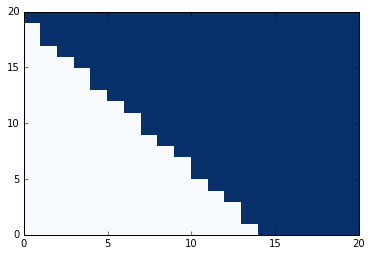

In [26]:
# update the first step
step_1 = [[(3,10),(7,13)]]
suite.UpdateSet(step_1)

# visualize the probablity
thinkplot.Contour(suite.GetDict(), contour=False, pcolor=True)

As we can see, after taking the first step, the frog has narrowed down a little bit of its searching area. Now let's go from (7,13) to (6,16). Since the noise got weaker in that step, we are going to reverse their order as input

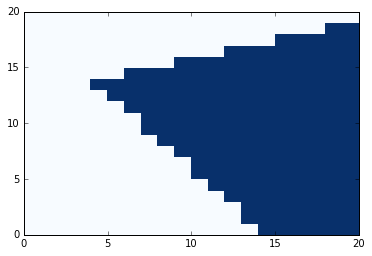

In [27]:
# update the first step
step_2 = [[(6,16),(7,13)]]
suite.UpdateSet(step_2)

# visualize the probablity
thinkplot.Contour(suite.GetDict(), contour=False, pcolor=True)

After the second step, the search area further decreased to smaller region. Now let's go from (6, 16) to (8, 19) and see what will happen

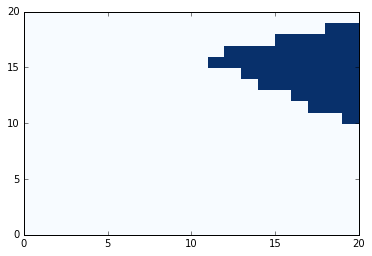

In [29]:
# update the first step

step_3 = [[(6,16),(8,19)]]
suite.UpdateSet(step_3)

# visualize the probablity
thinkplot.Contour(suite.GetDict(), contour=False, pcolor=True)

After the three steps, the search area shrinks down to upper right conner of the room. That's the possible location of the bug

## Project progress

I’m thinking about a problem when waiting for the Wellesley shuttle near Chapel under the big oak tree. I saw oaks falling from the tree. Imagine that the tree covers a circle of certain radius. Every minute there is an acorn fall down from the tree. And the chance of an acorn will fall at the covered circle can be modeled as a two dimensional normal distribution. What is the chance that I will be hit by an acorn given the position I’m standing, the radius of me and how long I’m standing. I think it will be an interesting question for me to solve for the final project, so that students waiting for wellesley shuttle has a better idea the chance they will get hit by acorns. 